
BASIC SUMMARY STATISTICS

                               Mean   Median     Mode  Missing Values
Customer ID            25017.632092  25011.0  48382.0               0
Product Price            254.742724    255.0    290.0               0
Quantity                   3.004936      3.0      4.0               0
Total Purchase Amount   2725.385196   2725.0   2533.0               0
Customer Age              43.798276     44.0     47.0               0
Returns                    0.405904      0.0      0.0               0
Age                       43.798276     44.0     47.0               0
Churn                      0.200520      0.0      0.0               0


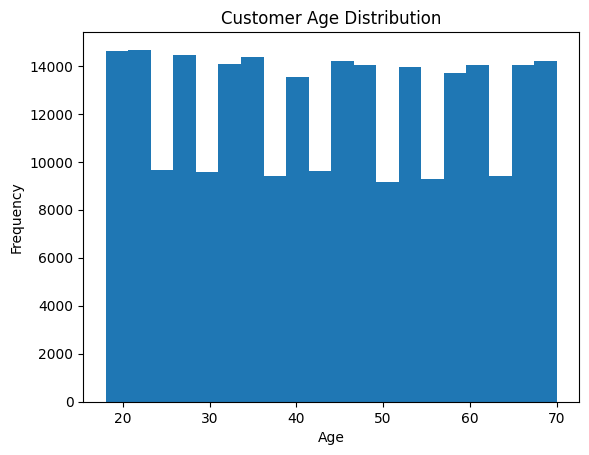

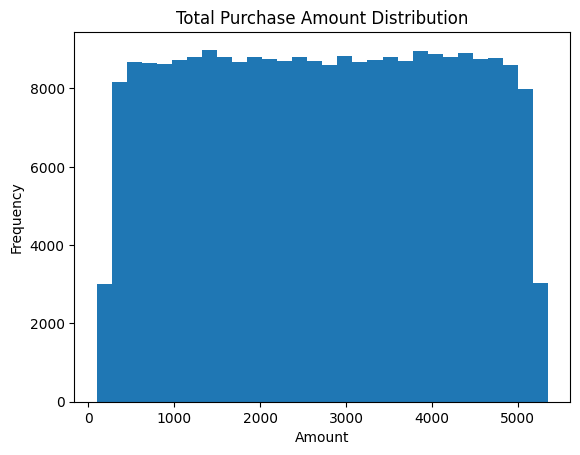

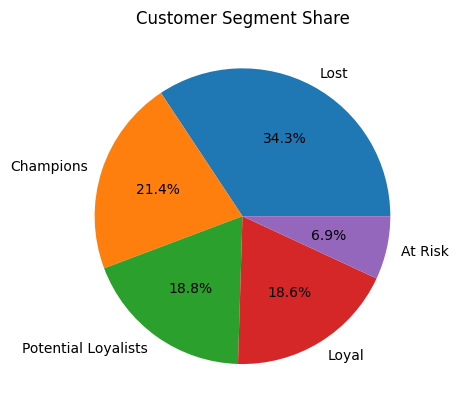

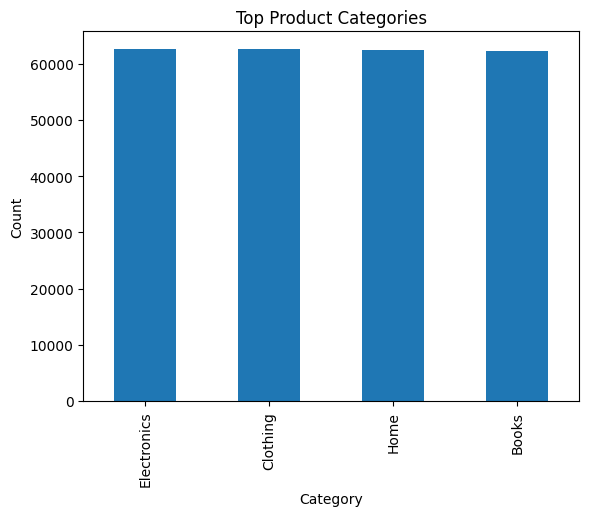

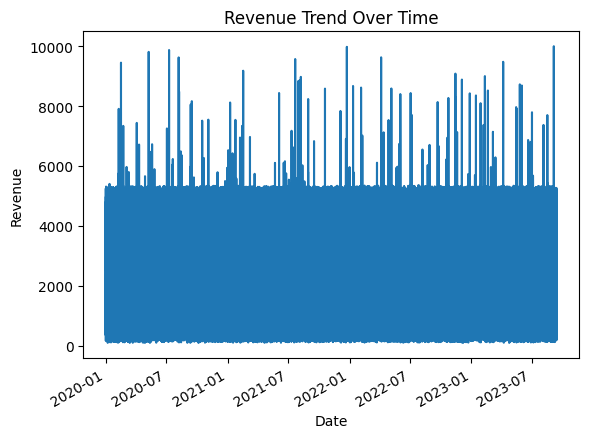


SEGMENT SUMMARY

                        Recency  Frequency      Monetary          AOV  \
Segment                                                                 
At Risk              750.676462   1.650858   4494.043352  2726.660605   
Champions             60.474920   7.374883  20082.519444  2724.314341   
Lost                 378.728954   3.801573  10386.576846  2733.985525   
Loyal                292.473530   6.992732  19050.219245  2724.881767   
Potential Loyalists   65.086318   3.924298  10676.806670  2720.014846   

                     Churn_Risk  
Segment                          
At Risk                     1.0  
Champions                   0.0  
Lost                        0.0  
Loyal                       0.0  
Potential Loyalists         0.0  


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ===============================
# 1. LOAD DATA
# ===============================
df = pd.read_csv("/content/sample_data/ecommerce_customer_data_custom_ratios.csv")
df = pd.read_csv("/content/sample_data/ecommerce_customer_data_large.csv")
# ===============================
# 2. DATA CLEANING
# ===============================
df.drop_duplicates(inplace=True)
df["Purchase Date"] = pd.to_datetime(df["Purchase Date"])
df["Returns"] = df["Returns"].fillna(0)

# ===============================
# 3. BASIC STATISTICS
# ===============================
numeric_cols = df.select_dtypes(include="number").columns

stats = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Median": df[numeric_cols].median(),
    "Mode": df[numeric_cols].mode().iloc[0],
    "Missing Values": df[numeric_cols].isnull().sum()
})

print("\nBASIC SUMMARY STATISTICS\n")
print(stats)

# ===============================
# 4. FEATURE ENGINEERING (RFM)
# ===============================
reference_date = df["Purchase Date"].max()

rfm = df.groupby("Customer ID").agg({
    "Purchase Date": lambda x: (reference_date - x.max()).days,
    "Customer ID": "count",
    "Total Purchase Amount": "sum",
    "Returns": "sum"
}).rename(columns={
    "Purchase Date": "Recency",
    "Customer ID": "Frequency",
    "Total Purchase Amount": "Monetary"
})

rfm["AOV"] = rfm["Monetary"] / rfm["Frequency"]

rfm["Churn_Risk"] = np.where(
    (rfm["Recency"] > rfm["Recency"].quantile(0.75)) &
    (rfm["Frequency"] < rfm["Frequency"].quantile(0.25)),
    1, 0
)

# ===============================
# 5. RFM SCORING & SEGMENTS
# ===============================
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])

def segment(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4:
        return "Champions"
    elif row["F_Score"] >= 4:
        return "Loyal"
    elif row["R_Score"] >= 4:
        return "Potential Loyalists"
    elif row["Churn_Risk"] == 1:
        return "At Risk"
    else:
        return "Lost"

rfm["Segment"] = rfm.apply(segment, axis=1)

# ===============================
# 6. VISUALIZATIONS
# ===============================

# Histogram: Customer Age
plt.figure()
plt.hist(df["Customer Age"], bins=20)
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Histogram: Total Purchase Amount
plt.figure()
plt.hist(df["Total Purchase Amount"], bins=30)
plt.title("Total Purchase Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Pie Chart: Customer Segments
plt.figure()
rfm["Segment"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Customer Segment Share")
plt.ylabel("")
plt.show()

# Bar Chart: Product Category
plt.figure()
df["Product Category"].value_counts().head(10).plot(kind="bar")
plt.title("Top Product Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Line Chart: Revenue Over Time
plt.figure()
df.groupby("Purchase Date")["Total Purchase Amount"].sum().plot()
plt.title("Revenue Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# ===============================
# 7. SEGMENT SUMMARY
# ===============================
segment_summary = rfm.groupby("Segment").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "AOV": "mean",
    "Churn_Risk": "mean"
})

print("\nSEGMENT SUMMARY\n")
print(segment_summary)
